# Semantic Segmentation of cars

## Overview

This project tries to carry out the image segmentation as described in:
https://www.kaggle.com/c/carvana-image-masking-challenge/overview

Sagemaker resource

For this project, the segmentation can be done by

Docs: https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html

## Dataset Preparation

In [2]:
!pip3 install tqdm
!pip3 install pillow --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Requirement already up-to-date: pillow in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (7.2.0)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import math

In [4]:
# role and session
role = sagemaker.get_execution_role()

sagemaker_session = sagemaker.Session()

# S3 bucket name
bucket_name = sagemaker_session.default_bucket()

In [5]:
# Getting the Container image for Sagemaker's segmentation 

training_image = get_image_uri(boto3.Session().region_name, "semantic-segmentation",
                              repo_version="latest") 
training_image

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


'811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:latest'

## Data Processing on S3

The data was directly uploaded to the S3 after downloading it from the Kaggle website. Assigning the path names to refer to later.

In [5]:
prefix = 'car_segmentation'

s3_train_path = f's3://{bucket_name}/{prefix}/train'

s3_train_annotation_path = f's3://{bucket_name}/{prefix}/train_annotation'

s3_validation_path = f's3://{bucket_name}/{prefix}/validation'

s3_validation_annotation_path = f's3://{bucket_name}/{prefix}/validation_annotation' 

## Building Estimator for our model


In [20]:
estimator = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge', 
    train_volume_size=100,  # In GB
    train_max_run=36000,    # max time in s
    input_mode = 'File',    # As here we've structured the files in train & valid folders
    output_path = f's3://{bucket_name}/{prefix}/output',
    sagemaker_session = sagemaker_session
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


## Hyperparameters

Reference: https://docs.aws.amazon.com/sagemaker/latest/dg/segmentation-hyperparameters.html

In [21]:
bucket_name, f'{prefix}/train'

('sagemaker-us-east-1-185596030677', 'car_segmentation/train')

In [22]:
train_images = sagemaker.session.Session.list_s3_files(sagemaker_session, bucket_name, f'{prefix}/train')
print(len(train_images))

8050


In [23]:
estimator.set_hyperparameters(
    backbone = 'resnet-50',
    algorithm = 'psp',  # Options: fcn, psp, deeplab
    use_pretrained_model = True,
    crop_size = 240,
    num_classes = 2,   # We only have a 0 or 1 class in our images
    num_training_samples = len(train_images),
    epochs = 5,
    learning_rate = 0.0001,
    optimizer = 'rmsprop',
    lr_scheduler = 'poly',    # Alternatives: cosine, step schedulers
    mini_batch_size = 16,
    validation_mini_batch_size = 16
)

In [24]:
distribution = 'FullyReplicated'
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_path, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation_path, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation_path, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


## Model Training

In [25]:
%%time

estimator.fit(inputs=data_channels, logs=True)

2020-08-02 16:50:36 Starting - Starting the training job...
2020-08-02 16:50:38 Starting - Launching requested ML instances......
2020-08-02 16:51:51 Starting - Preparing the instances for training.........
2020-08-02 16:53:11 Downloading - Downloading input data............
2020-08-02 16:55:35 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[08/02/2020 16:55:39 INFO 139952905316160] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_t

[08/02/2020 17:06:57 INFO 139952905316160] #progress_notice. epoch: 0, iterations: 20 speed: 21.0200237047 samples/sec
[08/02/2020 17:07:12 INFO 139952905316160] #progress_notice. epoch: 0, iterations: 40 speed: 21.3466540915 samples/sec
[08/02/2020 17:07:19 INFO 139952905316160] #quality_metric. host: algo-1, epoch: 0, validation pixel_accuracy: 0.9858630288052721 .
[08/02/2020 17:07:19 INFO 139952905316160] #quality_metric. host: algo-1, epoch: 0, validation mIOU: 0.9665366553526451 .
[08/02/2020 17:07:19 INFO 139952905316160] #throughput_metric. host: algo-1, epoch: 0, validation throughput: 18.7884886224 samples/sec.
[08/02/2020 17:07:19 INFO 139952905316160] Serializing model to /opt/ml/model/model_best.params
[08/02/2020 17:07:19 INFO 139952905316160] Serializing model to /opt/ml/model/model_best.params
[08/02/2020 17:07:20 INFO 139952905316160] #progress_metric: host=algo-1, completed 20 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, 

[08/02/2020 17:31:26 INFO 139952905316160] #progress_notice. epoch: 3, iterations: 20 speed: 6.42102772436 samples/sec learning_rate: 0.000072
[08/02/2020 17:32:16 INFO 139952905316160] #progress_notice. epoch: 3, iterations: 40 speed: 6.42003812865 samples/sec learning_rate: 0.000071
[08/02/2020 17:33:06 INFO 139952905316160] #progress_notice. epoch: 3, iterations: 60 speed: 6.43881059502 samples/sec learning_rate: 0.000070
[08/02/2020 17:33:57 INFO 139952905316160] #progress_notice. epoch: 3, iterations: 80 speed: 6.44281937018 samples/sec learning_rate: 0.000070
[08/02/2020 17:34:47 INFO 139952905316160] #progress_notice. epoch: 3, iterations: 100 speed: 6.40109882144 samples/sec learning_rate: 0.000069
[08/02/2020 17:35:37 INFO 139952905316160] #progress_notice. epoch: 3, iterations: 120 speed: 6.42200656317 samples/sec learning_rate: 0.000068
[08/02/2020 17:36:27 INFO 139952905316160] #progress_notice. epoch: 3, iterations: 140 speed: 6.38814881716 samples/sec learning_rate: 0.000


2020-08-02 17:54:35 Completed - Training job completed
Training seconds: 3684
Billable seconds: 3684
CPU times: user 8.65 s, sys: 322 ms, total: 8.97 s
Wall time: 1h 4min 15s


## Model Deployment

In [26]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


------------------!

In [8]:
# Loading pretrained model

model_file = 'https://sagemaker-us-east-1-185596030677.s3.amazonaws.com/car_segmentation/output/semantic-segmentation-2020-08-02-16-50-35-892/output/model.tar.gz'

pretrainedmodel = sagemaker.model.Model(
    model_data=model_file,
    image=training_image,
    role=role)  # your role here; could be different name

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [9]:
predictor = pretrainedmodel.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

-----------------!

In [12]:
pretrainedmodel.content_type = 'image/jpeg'
pretrainedmodel.accept = 'image/png'

Assigning the type of file for the deployed model

In [10]:
predictor.content_type = 'image/jpeg'
predictor.accept = 'image/png'

AttributeError: 'NoneType' object has no attribute 'content_type'

## Predictions

Now we'll be testing on the test folder

In [13]:
import glob
import os
import os.path as osp

In [14]:
def filename(file):
    return osp.splitext(osp.basename(file))[0]

test_imgs = list(map(filename, glob.glob('test/*')))
test_annot = list(map(filename, glob.glob('test_annotation/*')))

assert sorted(test_imgs)==sorted(test_annot), 'Difference in image and annotations present'
print('All files matched!')

All files matched!


In [20]:
name = "semantic-segmentation-2020-08-02-21-42-45-204"

predictor = sagemaker.predictor.RealTimePredictor(
    endpoint=name,
    content_type='image/jpeg',
    accept='image/png')

In [21]:
index = 20

image_path = osp.join('test', f'{test_imgs[index]}.jpg')

with open(image_path, 'rb') as f:
    b = bytearray(f.read())
    
results = predictor.predict(b)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from model with message "Your invocation timed out while waiting for a response from container model. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/semantic-segmentation-2020-08-02-21-42-45-204 in account 185596030677 for more information.

### Prediction Manipulation

The dataset provided has very high quality images (pixel size of: 1918,1280)
Resizing the image to half the height and width resulted in returning the image

In [79]:
test_imgs

['6ae670e86620_04',
 'be86e79f1225_13',
 'a7c1ef8d9cc9_08',
 '42b3feca1993_10',
 '32ff007d9505_12',
 '3afec4b5ac07_10',
 '4a4364d7fc6d_07',
 '28d7fb5ba432_06',
 'cf5add31c130_16',
 'fff9b3a5373f_05',
 'c353e364e931_15',
 '2267f4aa0d2c_05',
 'a7c1ef8d9cc9_12',
 '717689f3e788_11',
 '5bc30efeb7bf_05',
 '11f3dc041cfb_07',
 'feaf59172a01_05',
 '11acc40dc0ea_02',
 '880ab8468df2_05',
 'efaef69e148d_13',
 '364fd5fd7569_11',
 'df642435a951_02',
 'cf5add31c130_14',
 'bf9932f7aca8_04',
 '65051cfe0789_11',
 '5d95d80e10a9_15',
 'c3614abc7405_13',
 'f3b482e091c0_05',
 'f7ad86e13ed7_06',
 '3d7a1030deeb_07',
 '169f5f6d8c9d_04',
 '3f8d611822bc_02',
 '1aba91a601c6_14',
 'f7ad86e13ed7_05',
 '04bd942b463b_16',
 'ed13cbcdd5d8_15',
 '65051cfe0789_07',
 'be86e79f1225_04',
 '78f63d808555_13',
 '42d81612e2ce_01',
 'ad5a6a058944_09',
 '0d1a9caf4350_11',
 '7ac210ba75a1_13',
 '98ee0624de87_10',
 '9cc257b449d0_07',
 'c9f382c7349e_07',
 '42415ff65013_12',
 '5ab34f0e3ea5_10',
 'a3e2e104d58a_12',
 '858841907a4a_12',


In [22]:
def resize_image(image_path):
    """Halving the image size to receive ouput from the endpoint"""
    
    img = Image.open(image_path)
    
    x, y = img.size
    x2, y2 = math.floor(x/2), math.floor(y/2)
    resized_img = img.resize((x2,y2),Image.ANTIALIAS)

    return resized_img

1918,1280->959,640


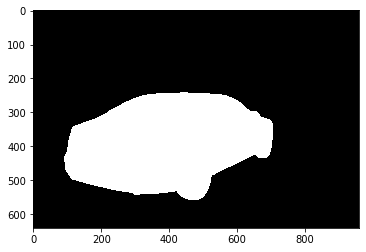

In [83]:
im0=test_imgs[0]

annot_folder = 'test_annotation'

image_path = osp.join(annot_folder, f'{test_imgs[index]}.png')
annot_img = Image.open(image_path)

x, y = annot_img.size
x2, y2 = math.floor(x/2), math.floor(y/2)
print(f'{x},{y}->{x2},{y2}')
annot_img = annot_img.resize((x2,y2),Image.ANTIALIAS)

plt.imshow(annot_img)

1918,1280->959,640


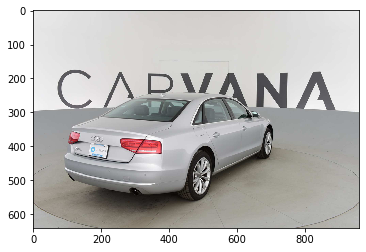

In [67]:
index = 20
image_path = osp.join(image_dir, images[index])
img = Image.open(image_path)

x, y = img.size
x2, y2 = math.floor(x/2), math.floor(y/2)
print(f'{x},{y}->{x2},{y2}')
img = img.resize((x2,y2),Image.ANTIALIAS)

plt.imshow(img)

In [72]:
img_arr

array([[[235, 235, 235],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [235, 235, 235]],

       [[235, 235, 235],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [235, 235, 235]],

       [[235, 235, 235],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [235, 235, 235]],

       ...,

       [[182, 182, 182],
        [182, 182, 182],
        [182, 182, 182],
        ...,
        [184, 185, 180],
        [184, 185, 180],
        [184, 185, 180]],

       [[182, 182, 182],
        [182, 182, 182],
        [182, 182, 182],
        ...,
        [184, 185, 180],
        [184, 185, 180],
        [184, 185, 180]],

       [[182, 182, 182],
        [182, 182, 182],
        [182, 182, 182],
        ...,
        [184, 185, 180],
        [184, 185, 180],
        [184, 185, 180]]

In [23]:
from PIL import Image

def img_to_bytes(img_arr):
#     img_arr = np.array(img)

    pil_im = Image.fromarray(img_arr)
    b = io.BytesIO()
    pil_im.save(b, 'jpeg')
    im_bytes = b.getvalue()
    return im_bytes

In [124]:
def predict_img(index):
    filename = test_imgs[index]
    
    image_path = osp.join('test', f'{test_imgs[index]}.jpg')
    annot_path = osp.join('test_annotation', f'{test_imgs[index]}.png')
    
    resized_image = resize_image(image_path)  # This will have the RGB channels present too
    resized_annot = resize_image(annot_path)    

    resized_image_arr = np.array(resized_image)  
    # (640, 959, 3)
    resized_annot_arr = np.array(resized_annot)    
    # (640, 959)

    im_bytes = img_to_bytes(resized_image_arr)
#     print(im_bytes)
    results = predictor.predict(im_bytes)    
    mask = np.array(Image.open(io.BytesIO(results)))    
    
    assert resized_annot_arr.shape==mask.shape, f'Shape mismatch {resized_annot_arr.shape}<>{mask.shape}'
    
    return resized_annot_arr, mask

# a,m = predict_img(1)

In [25]:
predict_img(100)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

### Evaluation of the model metrics

In [26]:
from sklearn.metrics import f1_score

def dice_coeff(annotation, mask):
    """The Dice coefficient for our 2 images"""
    
    annotation, mask = annotation.flatten(), mask.flatten()
    return f1_score(annotation, mask)

In [37]:
def evaluate():
    
    N = len(test_imgs)
    evaluated = 0
    sum_f1 = 0
    for i in tqdm(range(N)):
        
        if (i+1)%50==0:
            print(f'Iterating: {i+1}')
        
        try:
            annotation, mask = predict_img(i)

            f1 = dice_coeff(annotation, mask)
            sum_f1 += f1
            
            f = open('metrics.csv', 'w+')
            f.write(f'{i},{f1}\n')
            f.close()
            evaluated += 1

        except:
            continue
            
    avg_f1 = sum_f1 / evaluated
    print(f'Evaluated: {evaluated}, Average F1/Dice score: {avg_f1:0.4f}')
    return avg_f1 

In [38]:
f1_score = evaluate()

 18%|█▊        | 49/267 [11:18<50:58, 14.03s/it] 

Iterating: 50


 37%|███▋      | 99/267 [22:48<38:42, 13.82s/it]

Iterating: 100


 56%|█████▌    | 149/267 [34:20<27:09, 13.81s/it]

Iterating: 150


 75%|███████▍  | 199/267 [45:53<15:43, 13.88s/it]

Iterating: 200


 93%|█████████▎| 249/267 [57:28<04:10, 13.94s/it]

Iterating: 250


100%|██████████| 267/267 [1:01:37<00:00, 13.85s/it]

Evaluated: 267, Average F1/Dice score: 0.9859


### Visualizations

Visualizing the results we achieved with respect to the actual image

In [44]:
import cv2

In [106]:
def masked_image(img,mask):
    # The array of img and mask
    
    mask = np.stack((mask, mask, mask), axis=2)
    img_mask = img*mask
    return img_mask

In [125]:
def plots(index=None):
    
    if not index:
        index = random.choice(range(len(test_imgs)))

    fig, ax = plt.subplots(3,2, figsize = (15,15))
        
    image_path = osp.join('test', f'{test_imgs[index]}.jpg')
    
    resized_image = resize_image(image_path)  # This will have the RGB channels present too

    ax[0,0].imshow(resized_image)
    ax[0,0].title.set_text('Actual')
    ax[0,1].imshow(resized_image)
    ax[0,1].title.set_text('Prediction')
    
    annot, mask = predict_img(index)
    ax[1,0].imshow(annot)
    ax[1,1].imshow(mask)
    
    annotation_img = masked_image(resized_image,annot)
    mask_img = masked_image(resized_image,mask)
    
    ax[2,0].imshow(annotation_img)
    ax[2,1].imshow(mask_img)

Let's plot a couple of random cars and check the segmentation 

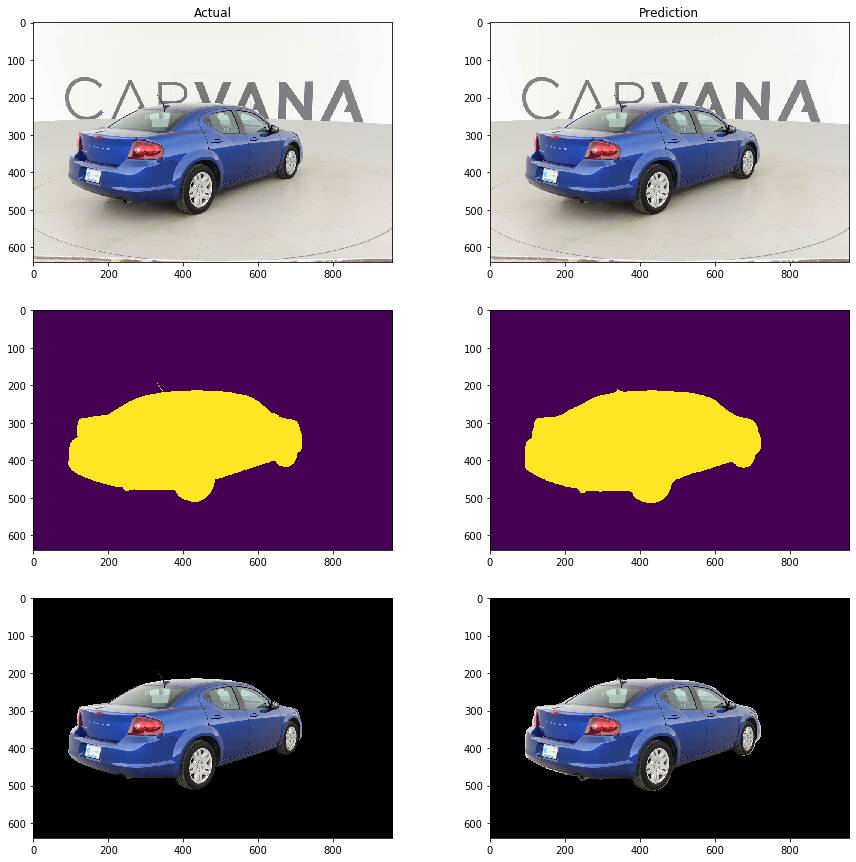

In [126]:
plots(52)

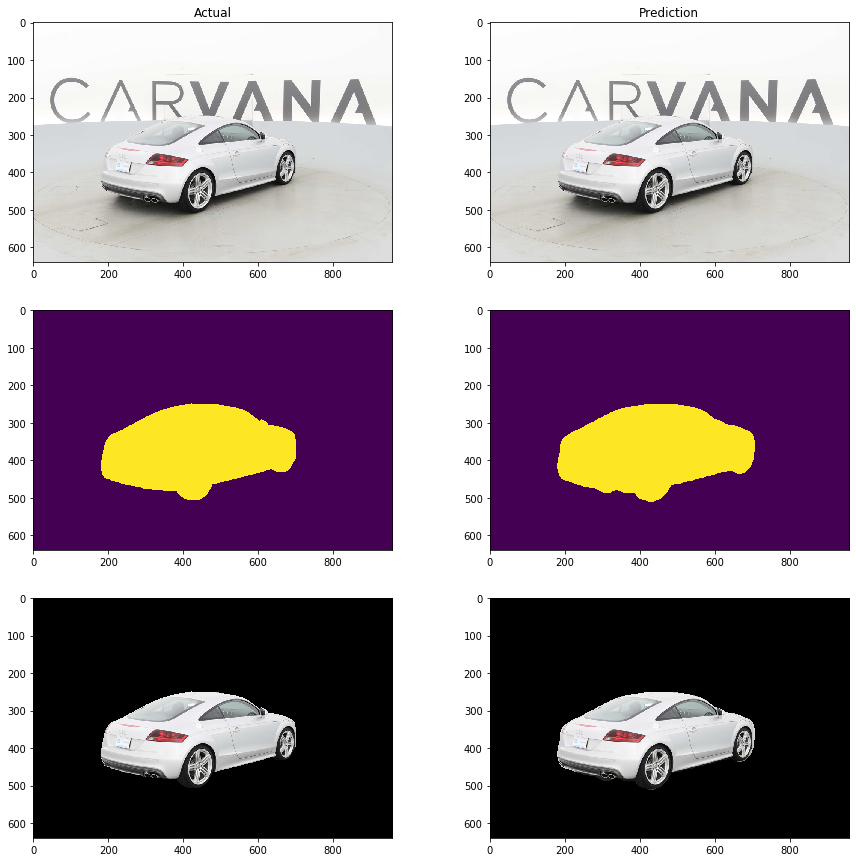

In [127]:
plots()